# Unsupervised Learning on [Airbnb](https://insideairbnb.com/get-the-data/) NYC Listings

                                                                                By Nikhil Ghugare and Prateek Pagare

### Set Up Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from ISLP.cluster import compute_linkage
from scipy.cluster.hierarchy import cut_tree

### Load and Clean the Airbnb NYC Dataset

In [18]:
df = pd.read_csv("listings.csv")
cols_used = [
    "name",                 
    "price",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
    "accommodates",
    "bathrooms",
    "bedrooms"
]

In [19]:
# Clean 'price' column
df["price"] = df["price"].replace({'\\$': '', ',' : ''}, regex=True).astype(float)

# Subset the dataframe
df_sub = df[cols_used].copy()

# Remove rows with any missing values
df_sub = df_sub.dropna()

# Drop rows with zero values in important numeric columns
numeric_cols = ["price", "accommodates", "bathrooms", "bedrooms","minimum_nights", "availability_365"]
for col in numeric_cols:
    df_sub = df_sub[df_sub[col] > 0]

# Remove price outliers above 95th percentile
price_cutoff = df_sub["price"].quantile(0.95)
df_sub = df_sub[df_sub["price"] <= price_cutoff]


In [20]:
# Preview cleaned dataset
df_sub.head()

,name,price,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,accommodates,bathrooms,bedrooms
1,Classical San Francisco Apartment in Pac Heigh...,150.0,30,31,2,0.05,358,1,2,1.0,1.0
2,Telegraph Hill-Full Bay View.Updated 1br++.Par...,140.0,30,365,21,0.13,107,1,3,1.0,1.0
4,Ocean Beach Sunset Loft,81.0,30,60,3,0.10,83,1,2,1.0,1.0
5,"Serenity by the Park , Your Golden Gate Getaway",113.0,1,365,79,6.29,113,1,3,1.0,1.0
6,Walking location with parking!,328.0,30,365,26,2.80,269,2,5,1.0,2.0


### Create Feature Matrix X and Standardize the Data

In [22]:
feature_cols = [
    "price",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
    "accommodates",
    "bathrooms",
    "bedrooms"
]

In [23]:
# Create matrix X
X = df_sub[feature_cols].values

# Standardize X to X_scaled
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Scale the data so all features have mean = 0 and standard deviation = 1
X_scaled[:5]

array([[-0.23514624,  0.38719274, -0.72064813, -0.5942644 , -0.70935231,
         1.45083596, -0.2868499 , -0.64446428, -0.44220142, -0.60269679],
       [-0.32531357,  0.38719274,  0.00873843, -0.45319111, -0.669473  ,
        -0.79611859, -0.2868499 , -0.10350732, -0.44220142, -0.60269679],
       [-0.85730078,  0.38719274, -0.65731816, -0.58683949, -0.68442774,
        -1.01096684, -0.2868499 , -0.64446428, -0.44220142, -0.60269679],
       [-0.56876534, -0.46321432,  0.00873843, -0.02254631,  2.40123365,
        -0.74240653, -0.2868499 , -0.10350732, -0.44220142, -0.60269679],
       [ 1.36983214,  0.38719274,  0.00873843, -0.41606655,  0.66149888,
         0.65410706, -0.25575902,  0.97840661, -0.44220142,  0.63440147]])

After scaling, we now have a matrix called X_scaled where each row represents a single Airbnb listing, and each column is one of the numeric features we're studying , things like price, number of reviews, bathrooms, bedrooms, and so on. Since we standardized all the features, each value in this matrix tells us how far that listing is from the average for that particular feature. A value of 0 means it's right around the average, positive values mean it's above average, and negative values mean it's below average. For example, if a listing has a price value of -0.2, that means its price is slightly lower than the average listing. If it has a value of 1.5 for availability, it’s much more available than most listings. This scaling step is really important because it puts all our features on the same footing, so price doesn’t dominate just because it’s measured in hundreds of dollars while number of bedrooms is usually just 1 or 2.

## Principal Component Analysis (PCA)

Now that the data is standardized, we use PCA to reduce the number of features and understand the main directions in which Airbnb listings vary. PCA takes our 10 numeric features and finds new variables called principal components that are combinations of the originals and explain the most variance in the dataset. We do this so we can simplify the data without losing too much information.we’re using PCA here because it’s easier to interpret for our purposes. PCA gives us the proportion of variance explained directly.

In [27]:
pca = PCA()
Z = pca.fit_transform(X_scaled) 
V = pca.components_              
pve = pca.explained_variance_ratio_
cum_pve = np.cumsum(pve)

In [28]:
print("Number of Principal Components:", pca.n_components_)

Number of Principal Components: 10


In [29]:
print("Shape of Z (PCA scores):", Z.shape)

Shape of Z (PCA scores): (4019, 10)


In [30]:
# Print proportion of variance explained
print("Proportion of variance explained (PVE):")
print(pve)

print("\nCumulative variance explained:")
print(cum_pve)

Proportion of variance explained (PVE):
[0.25862378 0.20669448 0.11287925 0.10077482 0.08433039 0.07425424
 0.06440504 0.0461223  0.03104875 0.02086695]

Cumulative variance explained:
[0.25862378 0.46531826 0.57819751 0.67897233 0.76330272 0.83755697
 0.901962   0.9480843  0.97913305 1.        ]


After running PCA, we now know how much variance each principal component explains. The first component explains about 26% of the total variation in the dataset. The second component adds another 21%, so together they capture about 47% of the variance, how many components do we actually need to keep? Based on this, it looks like the first 2–3 components already capture a good amount of structure, and if we want even more precision we can keep up to 5 or 6.

#### Visualizing Variance with Scree and Cumulative Plots

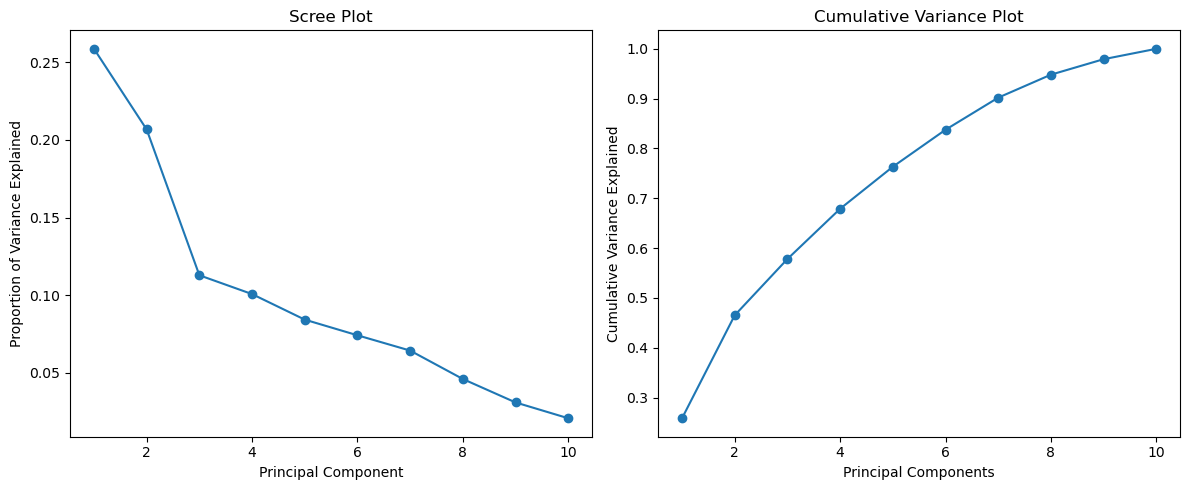

In [33]:
plt.figure(figsize=(12, 5))

# Scree Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pve) + 1), pve, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")

# Cumulative Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cum_pve) + 1), cum_pve, marker='o')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Plot")
plt.tight_layout()
plt.show()

Looking at the plots, we can see that the first two principal components already explain almost half the variation in the data. By the time we include around 5 components, we’ve captured more than 75%, which is pretty solid. This means we don’t need all 10 features to understand the main patterns, just a few of them carry most of the information. So we’ll mostly focus on the first 2 or 3 components 

#### Interpreting PCA Loadings 
Now that we’ve seen how many components to keep, we want to understand what those components actually mean.The loadings matrix (also rotation V) tells us how much each original variable contributes to each principal component.

In [36]:
np.round(pca.components_.T, 3)

array([[ 0.481,  0.054, -0.074,  0.105,  0.228,  0.121,  0.243,  0.783,
         0.08 , -0.066],
       [ 0.002, -0.372,  0.27 , -0.553, -0.265, -0.074,  0.635,  0.011,
         0.064,  0.023],
       [ 0.032, -0.35 ,  0.364, -0.179,  0.656, -0.437, -0.297,  0.027,
         0.036, -0.007],
       [-0.145,  0.52 ,  0.424, -0.066,  0.034, -0.133,  0.131,  0.144,
        -0.684,  0.026],
       [-0.108,  0.549,  0.397, -0.003,  0.038, -0.066,  0.093, -0.046,
         0.705, -0.125],
       [-0.067, -0.289,  0.577,  0.222,  0.008,  0.715, -0.131,  0.014,
        -0.03 , -0.03 ],
       [-0.088, -0.251,  0.186,  0.759, -0.176, -0.436,  0.31 ,  0.008,
         0.007, -0.007],
       [ 0.539,  0.124,  0.103,  0.089,  0.13 ,  0.053,  0.146, -0.375,
         0.007,  0.703],
       [ 0.353, -0.034,  0.265, -0.11 , -0.629, -0.25 , -0.531,  0.214,
         0.038,  0.07 ],
       [ 0.555,  0.044,  0.061,  0.034,  0.028, -0.002,  0.086, -0.421,
        -0.146, -0.692]])

This matrix shows how much each original feature contributes to each principal component. For example, PC1 seems to be influenced most by price, accommodates, and bedrooms, so it might be capturing listing size or value. PC2 is more about minimum_nights and number_of_reviews, which could reflect booking or host behavior.

### Simulate Missing Data and Perform PCA-Based Matrix Completion
We added this step to show how PCA can also be used for matrix completion — that is, filling in missing data. Even though our dataset didn’t actually have missing values (since we cleaned it earlier), we simulated a situation where 5% of the data was missing. This is something that happens all the time in real-world datasets. Using PCA, we reconstructed the missing entries based on patterns found in the rest of the data.

In [39]:
np.random.seed(42)
X_missing = X_scaled.copy()

mask = np.random.rand(*X_missing.shape) < 0.05

# Store original values for comparison
X_original_values = X_scaled[mask].copy()

X_missing[mask] = 0

In [40]:
# Apply PCA to  masked matrix
k = 5  # number of PCs to use for reconstruction
pca_k = PCA(n_components=k)
Z_k = pca_k.fit_transform(X_missing)
X_approx = pca_k.inverse_transform(Z_k)

In [41]:
reconstructed_values = X_approx[mask]
correlation = np.corrcoef(reconstructed_values, X_original_values)[0, 1]
print(f"Correlation between reconstructed and original missing values: {correlation:.4f}")

Correlation between reconstructed and original missing values: 0.5063


The correlation between the reconstructed values and the original ones for the missing entries is about 0.51. That means our PCA-based approximation did an okay job at recovering the missing values, but it’s definitely picking up on some of the structure in the data.

### K-means Clustering,
Now that we’ve reduced our dataset to principal components, we’ll apply K-means clustering using just the first two PCs (PC1 and PC2). These two components already capture the most important variation in the data.Since we don’t know how many clusters to expect, we’ll try values of k from 2 to 8 to evaluate

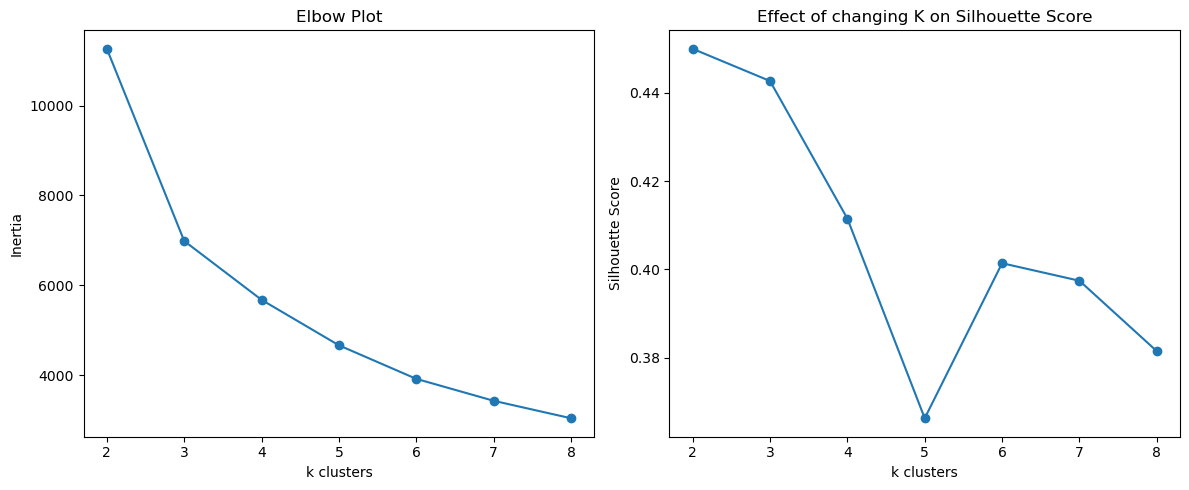

In [44]:
k_range = range(2, 9)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(Z[:, :2])  # use PC1 and PC2
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(Z[:, :2], labels, metric='euclidean'))

# Plot elbow and silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(k_range, inertias, marker='o')
ax[0].set_xlabel("k clusters")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Elbow Plot")

ax[1].plot(k_range, silhouettes, marker='o')
ax[1].set_xlabel("k clusters")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Effect of changing K on Silhouette Score")
plt.tight_layout()
plt.show()

Looking at the elbow plot, there’s a noticeable bend around k = 3, which means that adding more clusters beyond that doesn’t reduce inertia as much. The silhouette plot also shows that both k = 2 and k = 3 have the best scores, with k = 2 being slightly higher but k = 3 still quite strong. Based on this, we’ll choose **k = 3** as a good balance.


#### Final K-means Clustering at k = 3 with Centroid

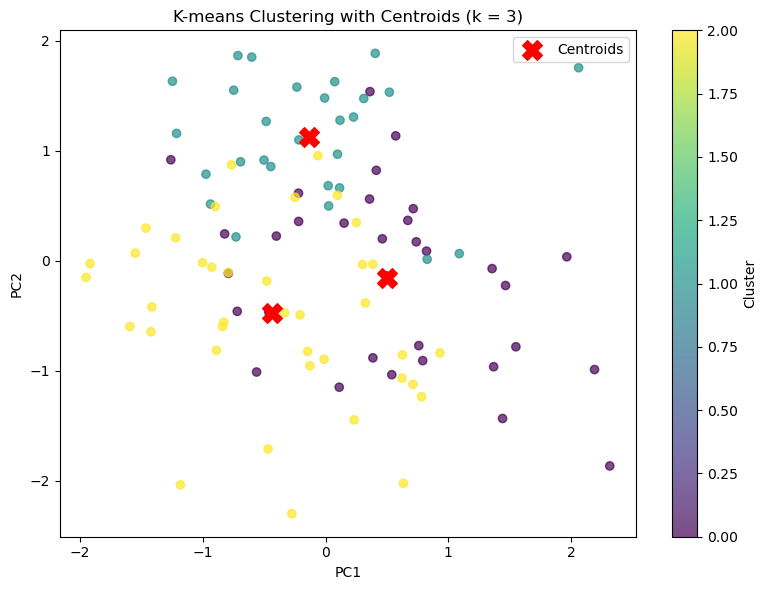

In [95]:
# Final KMeans Clustering with Centroids
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means Clustering with Centroids (k = 3)")
plt.colorbar(scatter, label="Cluster")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

This plot shows how the Airbnb listings were grouped into 3 clusters using their main features (PC1 and PC2). Each colored group represents a different type of listing, and the big red Xs show the "center" of each group, basically, an average spot that best represents that cluster. It’s a nice way to see how similar listings ended up together.

#### Final K-means Clustering at k = 3 


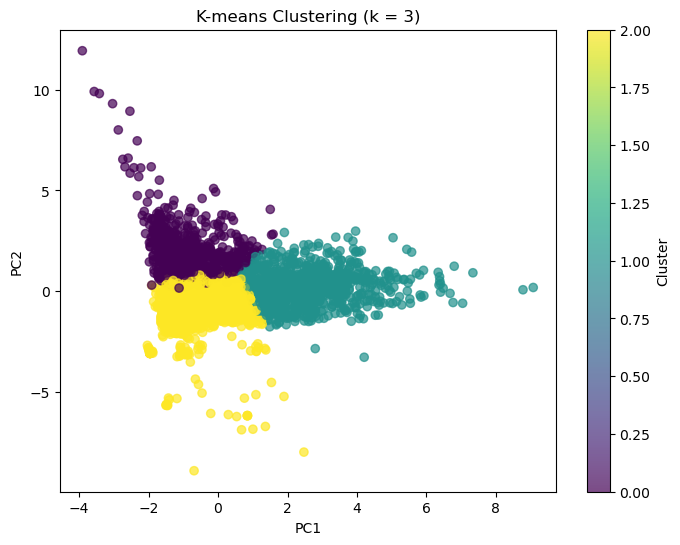

In [47]:
final_k = 3
kmeans_final = KMeans(n_clusters=final_k, n_init=10, random_state=42)
cluster_labels = kmeans_final.fit_predict(Z[:, :5])  # PC1 and PC2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means Clustering (k = 3)")
plt.colorbar(scatter, label="Cluster")
plt.show()

While the clustering was done using the first 5 principal components, we visualized the results in just the first two (PC1 and PC2) for easier interpretation. Each dot is a listing, and the color shows which cluster it was assigned to. The clusters are clearly separated in this 2D space, which suggests that Airbnb listings in NYC can be grouped into distinct patterns based on their features like price, availability, and review behavior.

#### Interpreting Cluster Characteristics
As we’ve clustered all listings, we want to understand what each group represents.
To do that, Assign the cluster labels back to the original cleaned datasetand then Group by cluster and calculate the average values of key features.

In [50]:
df_clustered = df_sub.copy()
df_clustered['cluster'] = cluster_labels

# Calculate mean of each feature by cluster
cluster_summary = df_clustered.groupby('cluster')[feature_cols].mean().round(2)
cluster_summary

,price,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,accommodates,bathrooms,bedrooms
cluster,,,,,,,,,,
0,133.64,2.37,138.15,258.03,4.01,159.09,2.63,2.78,1.09,1.15
1,316.22,13.22,359.98,46.43,1.15,171.06,4.08,5.67,1.84,2.65
2,136.91,23.91,449.31,26.82,0.60,220.39,15.68,2.37,1.14,1.16


Looking at the table of averages, each cluster reflects a different kind of Airbnb listing.

- Cluster 0 looks like the busy budget listings, they’re cheaper \$133.64 on an average, active with 258 reviews, and get booked often (about 4 reviews per month) according to summary as we can look, usually host 2–3 people with 1 bedroom.
- Cluster 1 stands out as the high-end or group-style rentals, they’re expensive about \$316.22,can  fit around 5–6 guests, and require longer stays (minimum 13 nights).
- Cluster 2 prices are similar to Cluster 0 about $136.91, but they require very long stays minimum 24 nights, and are managed by hosts who have lots of listings over 15 on average, which suggests these are likely commercial or long-term rental properties. Each cluster clearly reflects a different hosting style on Airbnb.

Overall, the clustering helped uncover three clear groups with distinct rental behaviors.

### Hierarchical Clustering with Dendrograms

Now we’ll explore hierarchical clustering using three different linkage types- complete, average, and single.
We use AgglomerativeClustering with no pre-specified number of clusters (distance_threshold=0), and visualize the hierarchy using dendrograms. 

#### 1.) Complete Linkage
In this distance between clusters is defined by the maximum pairwise distance between their observations.

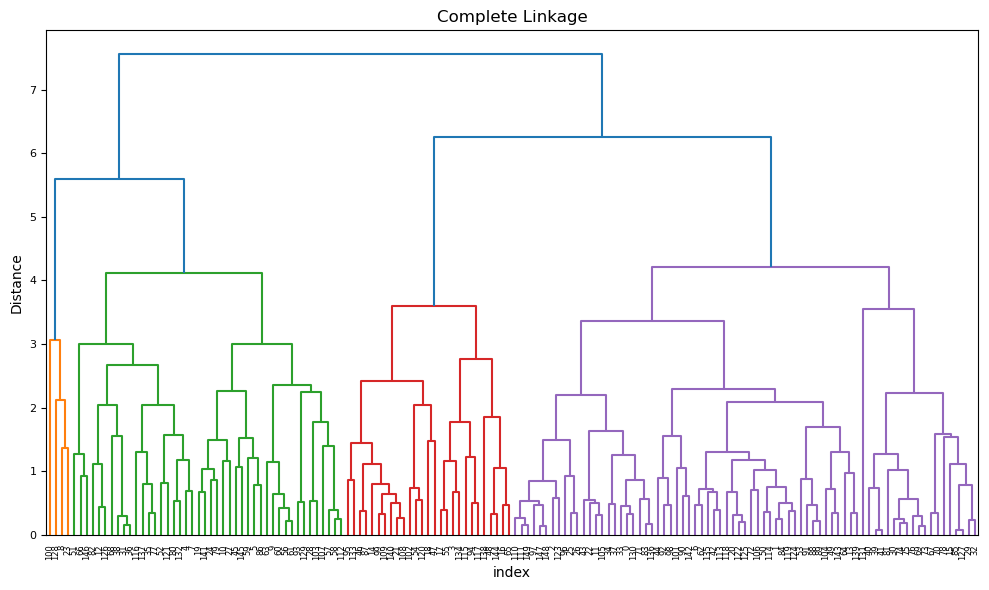

In [54]:
X_sample = Z[:150, :5]

# Complete linkage
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X_sample)

# Plot dendrogram
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(figsize=(10, 6))
dendrogram(linkage_comp, ax=ax)
ax.set_title("Complete Linkage")
ax.set_xlabel("index")
ax.set_ylabel("Distance")
ax.grid(False)             
plt.xticks(rotation=90, fontsize=6)  
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

This dendrogram shows how Airbnb listings group together using complete linkage, where clusters are merged based on the farthest pairwise distance between their points. We can see that a few distinct clusters start to form around a distance of 3 to 4 ,these represent groups of listings that are more similar to each other and more distant from other groups.Overall, complete linkage creates well-separated, compact clusters, which helps highlight truly distinct listing types in the NYC

#### 2.) Average Linkage
Here we will do Average linkage, where clusters are merged based on average distance between all points in the two clusters.

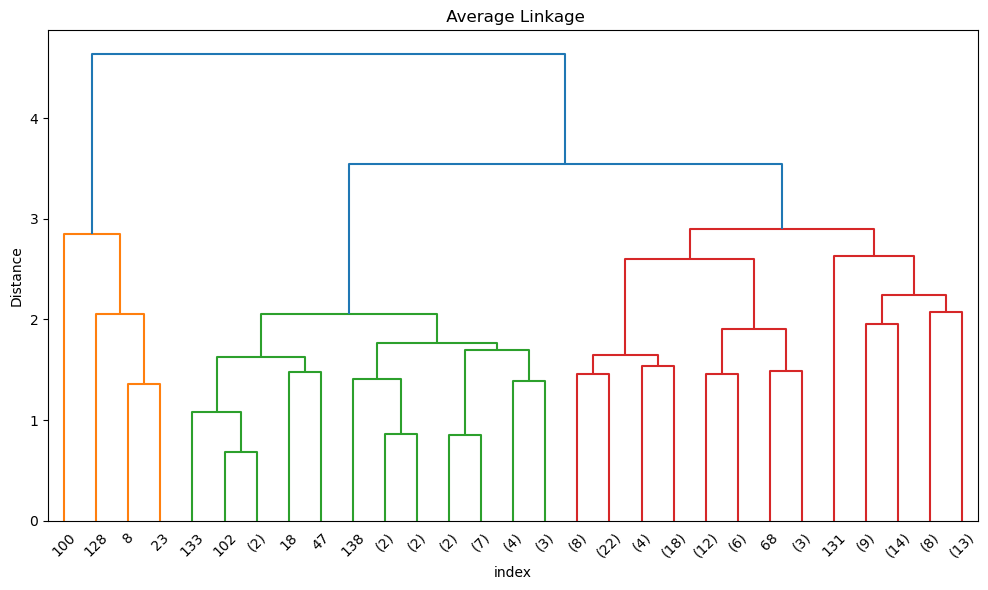

In [57]:
hc_avg = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='average')
hc_avg.fit(X_sample)

# Plot dendrogram
linkage_avg = compute_linkage(hc_avg)
fig, ax = plt.subplots(figsize=(10, 6))
dendrogram(linkage_avg,ax=ax,truncate_mode='level', p=5)
ax.set_title(" Average Linkage")
ax.set_xlabel("index")
ax.set_ylabel("Distance")
ax.grid(False)
plt.tight_layout()
plt.show()

Compared to complete linkage, the structure here feels more balanced and smoother clusters tend to merge at slightly lower distances. This method doesn’t force compactness like complete linkage, so it often forms more flexible, rounded groupings. In our Airbnb data, this might reflect how some listings are more averagely close to multiple others, rather than being tightly

#### 3.) Single Linkage
Finally, use single linkage, where clusters are merged based on the minimum distance between points across clusters.

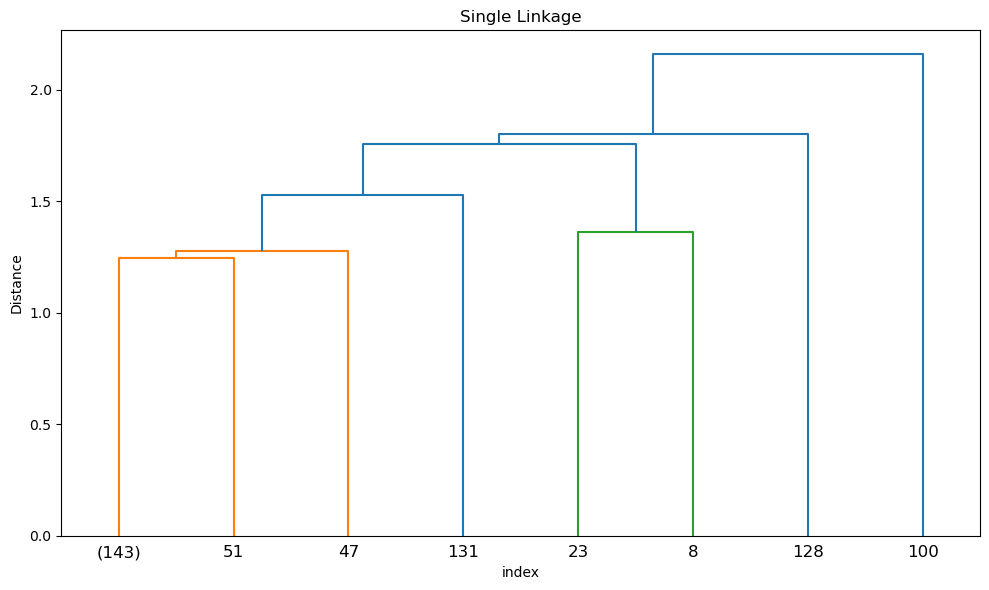

In [60]:
# Fit model with single linkage
hc_sing = AgglomerativeClustering(distance_threshold=0,
                                   n_clusters=None,
                                   linkage='single')
hc_sing.fit(X_sample)

# Plot dendrogram
linkage_sing = compute_linkage(hc_sing)
fig, ax = plt.subplots(figsize=(10, 6))
dendrogram(linkage_sing, ax=ax, truncate_mode='level', p=5)
ax.set_title("Single Linkage")
ax.set_xlabel("index")
ax.set_ylabel("Distance")
ax.grid(False)
plt.tight_layout()
plt.show()

As expected, the structure is quite flat and stretched out clusters join together quickly, even when the overall groups aren’t that similar. This happens because single linkage is very sensitive to chaining, once two close points are connected, the cluster grows even if others are far apart.

#### Cut clusters from Complete Linkage
To explore how listings group together based on the dendrogram, we can cut the hierarchy at a selected number of clusters , k = 3.

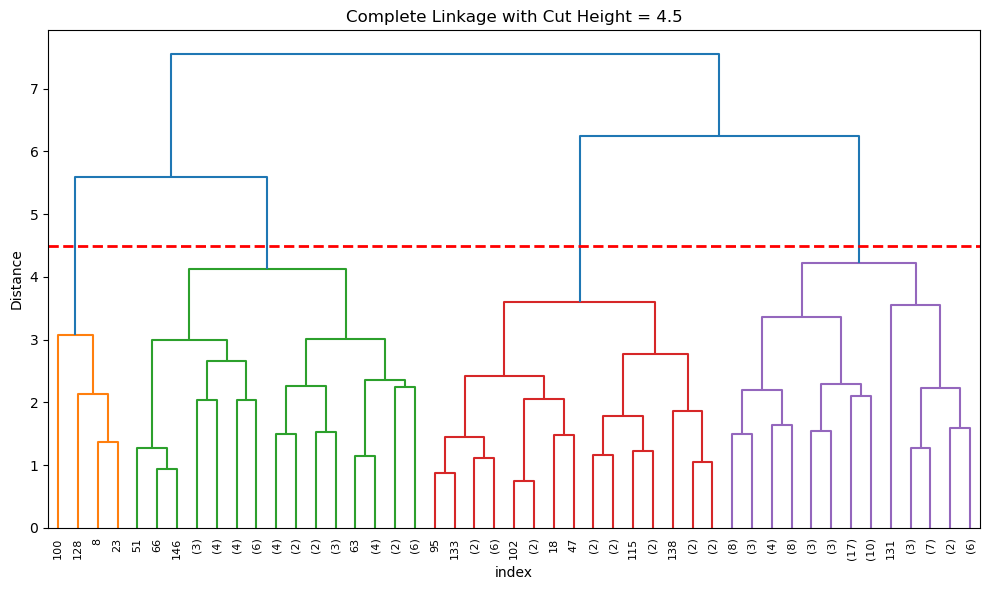

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
dendrogram(linkage_comp,ax=ax,truncate_mode="level",p=5)

ax.axhline(y=4.5, color="red", linestyle="--", linewidth=2)
ax.set_title("Complete Linkage with Cut Height = 4.5")
ax.set_xlabel("index")
ax.set_ylabel("Distance")
ax.grid(False)
plt.tight_layout()
plt.show()

In [64]:
# Cut the complete linkage dendrogram at k = 3 clusters
cluster_assignments = cut_tree(linkage_comp, n_clusters=3).flatten()
print(" 150 cluster labls from complete linkage cut:", cluster_assignments[:150])

 150 cluster labls from complete linkage cut: [0 0 0 1 2 2 0 2 2 2 2 0 2 0 1 0 1 1 1 2 0 1 0 2 2 0 0 2 2 0 0 2 0 0 0 2 2
 0 2 0 0 0 0 0 0 2 1 1 1 0 0 2 2 0 1 1 2 2 2 2 2 2 0 2 0 1 2 0 2 0 0 0 0 0
 0 0 0 2 0 2 2 0 2 0 0 0 2 1 0 0 0 0 0 2 1 1 0 0 0 1 2 0 1 2 0 0 0 2 1 1 0
 0 2 0 0 1 2 1 0 0 1 2 0 0 0 0 2 0 2 2 0 0 2 1 1 0 0 2 1 0 1 2 0 0 1 2 2 0
 0 0]


we cut the dendrogram at a distance of 4.5, which naturally split the hierarchy into 3 clusters. This grouped the 150 listings into 3 distinct sets based on their similarity using complete linkage. The resulting cluster labels (0, 1, and 2) now give us a way to analyze what makes each group different 

### Summary

just by looking at data like price, availability, reviews, and host behavior. Using unsupervised learning tools like PCA, matrix completion, k-means, and hierarchical clustering, we were able to uncover some really interesting insights. For example, one group of listings clearly stood out as budgetfriendly and available most of the year, likely personal or part-time rentals. Another group had much higher prices, fewer reviews, and larger accommodations, possibly luxury or commercial listings. And finally, we spotted a cluster of properties that seemed to be managed by hosts who run multiple listings at once, maybe Airbnb “power users.” Overall, this project showed us how realworld data can reveal hidden patterns, even without labels, and how techniques like PCA and clustering can help make sense rental market like New York's airbnb.

### Reference

- Inside Airbnb Data: http://insideairbnb.com/get-the-data.html
- scikit-learn Documentation: https://scikit-learn.org/stable/
- Clustering in ML : https://scikit-learn.org/stable/modules/clustering.html
- ISLP Textbook and Lecture Code: Ch12-1.ipynb, Ch12-2.ipynb
- PCA: https://www.geeksforgeeks.org/principal-component-analysis-pca/